# Train COIN

## Import libs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys,inspect
#sys.path.insert(0,"..")
os.chdir('..')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

import os
import random
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Reproducibility
random.seed(0)
os.environ['PYTHONHASHSEED'] = str(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

EXPERIMENT_NAME = "ssl_coin"

ROOT_DIR = os.path.abspath(".")
LOG_PATH = os.path.join(ROOT_DIR, "logs", EXPERIMENT_NAME)

if not os.path.exists(LOG_PATH):
    os.mkdir(LOG_PATH)
    
if not os.path.exists(os.path.join(LOG_PATH, "outs")):
    os.mkdir(os.path.join(LOG_PATH,"outs"))
    os.mkdir(os.path.join(LOG_PATH,"outs", "preds"))
    os.mkdir(os.path.join(LOG_PATH,"outs", "partials"))
    os.mkdir(os.path.join(LOG_PATH,"outs", "inputs"))

cuda:0


In [4]:
LOG_PATH

'/home/hasib/context-invariance/logs/ssl_coin'

## Helpers

In [5]:
def visualize(idx, **images):
    """Plot images in one row.""" 
    n = len(images)
    fig = plt.figure(figsize=(20, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).lower(), fontsize=20)
        plt.imshow(image, cmap='gray')
        plt.axis("off")
        #plt.tight_layout()
    #plt.savefig("../outputs/vis/compare-segs/{}.png".format(idx), facecolor="white", bbox_inches = 'tight')
    plt.show()

## Load data

In [6]:
from dataset import ISIC2018Masked_dataloader

train_dataset = ISIC2018Masked_dataloader("datasets/ISIC2018")
test_dataset = ISIC2018Masked_dataloader("datasets/ISIC2018", is_train=False)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)

In [7]:
dt = next(iter(train_dataloader))
x = dt["image"]
y = dt["mask"]
z = dt["partial_image1"]
z2 = dt["partial_image2"]
x.shape, y.shape, z.shape, z2.shape

(torch.Size([8, 3, 192, 256]),
 torch.Size([8, 1, 192, 256]),
 torch.Size([8, 3, 192, 256]),
 torch.Size([8, 3, 192, 256]))

(192, 256, 3)


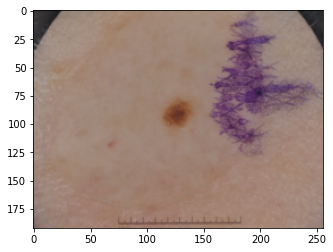

In [8]:
def to_img(ten):
    ten =(ten[0].permute(1,2,0).detach().cpu().numpy()+1)/2
    ten=(ten*255).astype(np.uint8)
    return ten

a = to_img(x)
print(a.shape)
#plt.imshow(a)
plt.imshow(a, cmap='gray')

In [9]:
# for xs, ys, zs, zs2 in zip(x,y,z,z2):
    
#     p_in = (zs.permute(1,2,0).detach().cpu().numpy()+1)/2
#     p_in = (p_in*255).astype(np.uint8)
    
#     p_in2 = (zs2.permute(1,2,0).detach().cpu().numpy()+1)/2
#     p_in2 = (p_in2*255).astype(np.uint8)
    
#     # Preprocess Input
#     xs = (xs.permute(1,2,0).detach().cpu().numpy()+1)/2
#     xs = (xs*255).astype(np.uint8)
    
#     # Preprocess Mask
#     ys =(ys.permute(1,2,0).detach().cpu().numpy()+1)/2
#     ys = (ys*255).astype(np.uint8)
    
#     visualize(0, input_image=xs, mask=ys, partial_input=p_in, partial_input_2=p_in2)

## Load model

In [10]:
from models import * 

# Define model
model = COIN_Unet()

# Send to GPU and initialize weights
model = model.to(DEVICE)
model.apply(weights_init)

COIN_Unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2)

## Setup optim and loss

In [11]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion_mae = torch.nn.L1Loss() # MAE, L1
criterion_mse = torch.nn.MSELoss() # MSE, L2

## Train and eval functions

In [12]:
def train(model, epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_dataloader):
        data, mask, partial1, partial2 = data["image"].to(DEVICE), data["mask"].to(DEVICE), data["partial_image1"].to(DEVICE), data["partial_image2"].to(DEVICE)
        
        # Pred
        output1, output2 = model.forward(partial1.float(), partial2.float())
        
        # Post process
        output1 = output1[:,0:3,:,:]
        output1 = torch.tanh(output1)
        
        output2 = output2[:,0:3,:,:]
        output2 = torch.tanh(output2)
        
        # One way loss
        # ssl_ae
        #loss = 0.9 * criterion_mse(output1.float(), data.float()) + 0.1 * criterion_mae(output1.float(), data.float())
        
        # Two way loss
        # ssl_coin
        loss_1 = 0.9 * criterion_mse(output1.float(), data.float()) + 0.1 * criterion_mae(output1.float(), data.float())
        #loss_2 = 0.9 * criterion_mse(output2.float(), data.float()) + 0.1 * criterion_mae(output2.float(), data.float())
        loss = loss_1
        #loss = 0.9 * loss_1 + 0.1 * loss_2
        
        train_loss += loss.item()
        
        # Update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        ######################
        if batch_idx == 0:
            # preds
            cv_img=(output1[0].permute(1,2,0).detach().cpu().numpy()+1)/2
            rgb=(cv_img*255).astype(np.uint8)
            bgr=cv2.cvtColor(rgb,cv2.COLOR_RGB2BGR)
            cv2.imwrite('{}/outs/preds/test'.format(LOG_PATH)+str(epoch)+'.jpg',bgr)

            # partial inputs
            xx=(partial1[0].permute(1,2,0).detach().cpu().numpy()+1)/2
            xx=(xx*255).astype(np.uint8)
            xx=cv2.cvtColor(xx,cv2.COLOR_RGB2BGR)
            cv2.imwrite('{}/outs/partials/test'.format(LOG_PATH)+str(epoch)+'.jpg',xx)

            # inputs
            yy=(data[0].permute(1,2,0).detach().cpu().numpy()+1)/2
            yy=(yy*255).astype(np.uint8)
            yy=cv2.cvtColor(yy,cv2.COLOR_RGB2BGR)
            cv2.imwrite('{}/outs/inputs/test'.format(LOG_PATH)+str(epoch)+'.jpg',yy)
        ######################
        
        # if batch_idx % 10 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_dataloader.dataset),
        #         100. * batch_idx / len(train_dataloader), loss.data))
        
    train_loss /= len(train_dataloader) 
    train_losses.append(train_loss)
    print('Average training loss: {:.3f}'.format(train_loss))


            
def test(model):
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for batch_idx, data in enumerate(train_dataloader):
            data, mask, partial = data["image"].to(DEVICE), data["mask"].to(DEVICE), data["partial_image1"].to(DEVICE)
            
            # Pred
            output, _ = model.forward(partial.float(), partial.float())
            output = output[:,0:3,:,:]
            output = torch.tanh(output)
            # Compute loss
            test_loss += criterion_mse(output.float(), data.float()).item()
        
        test_loss /= len(test_dataloader)
        test_losses.append(test_loss)
        
        print('Average test loss: {:.3f}'.format(test_loss))
        return test_loss

## Train model

In [13]:
train_losses = []
test_losses = []
score = 0
best_score = 100

start_time = time.time()

for epoch in range(1, 500):
    print("Epoch: {}".format(epoch))
    # Train
    train_score = train(model, epoch)
    # Test
    test_score = test(model)
    
    # Save best model
    if test_score < best_score:
        print("Saving model ------------------------------ at loss = {:.3f}.".format(test_score))
        torch.save(model.state_dict(), '{}/{}.pth'.format(LOG_PATH, EXPERIMENT_NAME))
        best_score = test_score

# Save losses
train_loss_history = np.array(train_losses)
np.savetxt("{}/{}_train_loss.txt".format(LOG_PATH, EXPERIMENT_NAME), train_loss_history, delimiter=",")
loss_history = np.array(test_losses)
np.savetxt("{}/{}_test_loss.txt".format(LOG_PATH, EXPERIMENT_NAME), loss_history, delimiter=",")

end_time = time.time()
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))
print("--- Time taken to train : %s mins ---" % ((end_time - start_time)//60))   

Epoch: 1
Average training loss: 0.070
Average test loss: 0.044
Saving model ------------------------------ at loss = 0.044.
Epoch: 2
Average training loss: 0.045
Average test loss: 0.060
Epoch: 3
Average training loss: 0.042
Average test loss: 0.079
Epoch: 4
Average training loss: 0.039
Average test loss: 0.040
Saving model ------------------------------ at loss = 0.040.
Epoch: 5
Average training loss: 0.038
Average test loss: 0.031
Saving model ------------------------------ at loss = 0.031.
Epoch: 6
Average training loss: 0.036
Average test loss: 0.042
Epoch: 7
Average training loss: 0.036
Average test loss: 0.048
Epoch: 8
Average training loss: 0.034
Average test loss: 0.034
Epoch: 9
Average training loss: 0.035
Average test loss: 0.041
Epoch: 10
Average training loss: 0.033
Average test loss: 0.039
Epoch: 11
Average training loss: 0.033
Average test loss: 0.046
Epoch: 12
Average training loss: 0.033
Average test loss: 0.034
Epoch: 13
Average training loss: 0.033
Average test loss: 

## Plot loss curves

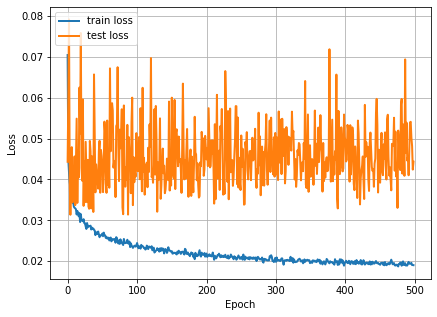

In [14]:
# Plot training & validation loss values
# b, g, r, y, o, -g, -m,
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(train_losses,linewidth=2)
plt.plot(test_losses,linewidth=2)
#plt.title('{} loss'.format("Exp name"))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'test loss'], loc='upper left')
plt.grid(True)
plt.savefig('{}/{}_graph.png'.format(LOG_PATH, EXPERIMENT_NAME), dpi=300)
plt.show()